In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

import sys
sys.path.append("../")

from utils.prep_utils import (
    COLORMAP,
    heatmaps_to_coordinates,
    N_KEYPOINTS,
    RAW_IMG_SIZE,
    MODEL_IMG_SIZE,
    show_batch_predictions,
    DATASET_MEANS,
    DATASET_STDS,
)
from utils.model import ShallowUNet
from utils.dataset import FreiHAND

### Inference Parameters

In [6]:
config = {
    "data_dir": "data/FreiHAND_pub_v2",
    "model_path": "weights/saved_model250",
    "test_batch_size": 4,
    "device": "cpu",
}

## Data

In [7]:
test_dataset = FreiHAND(config=config, set_type="test")
test_dataloader = DataLoader(
    test_dataset,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)

## Model

In [8]:
model = ShallowUNet(3, 21)
model.load_state_dict(
    torch.load(config["model_path"], map_location=torch.device(config["device"]))
)
model.eval()
print("Model loaded")

Model loaded


## Evaluate on Test Data

In [9]:
accuracy_all = []

for data in tqdm(test_dataloader):
    inputs = data["image"]
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
    accuracy_image = accuracy_keypoint.mean(axis=1)
    accuracy_all.extend(list(accuracy_image))

100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:00<00:00,  6.49it/s]


#### evaluation metric 1 : mean error per keypoint

In [10]:
error = np.mean(accuracy_all)
print("Average error per keypoint: {:.1f}% from image size".format(error * 100))

for img_size in [MODEL_IMG_SIZE, RAW_IMG_SIZE]:
    error_pixels = error * img_size
    image_size = f"{img_size}x{img_size}"
    print(
        "Average error per keypoint: {:.0f} pixels for image {}".format(
            error_pixels, image_size
        )
    )

Average error per keypoint: 3.8% from image size
Average error per keypoint: 5 pixels for image 128x128
Average error per keypoint: 8 pixels for image 224x224


#### evaluation metric 2: success rate for different thresholds

In [11]:
acc_0_01=[]
acc_0_02=[]
acc_0_03=[]
acc_0_04=[]
acc_0_05=[]
acc_0_1=[]
for i,x in enumerate(accuracy_all):
    if accuracy_all[i]<0.01:
        acc_0_01.append(accuracy_all[i])
    elif accuracy_all[i]<0.02:
        acc_0_02.append(accuracy_all[i])
    elif accuracy_all[i]<0.03:
        acc_0_03.append(accuracy_all[i])
    elif accuracy_all[i]<0.04:
        acc_0_04.append(accuracy_all[i])
    elif accuracy_all[i]<0.05:
        acc_0_05.append(accuracy_all[i])
    elif accuracy_all[i]<0.1:
        acc_0_1.append(accuracy_all[i])
acc_0_01v=(len(acc_0_01))
acc_0_02v=(acc_0_01v+len(acc_0_02))
acc_0_03v=(acc_0_02v+len(acc_0_03))
acc_0_04v=(acc_0_03v+len(acc_0_04))
acc_0_05v=(acc_0_04v+len(acc_0_05))
acc_0_1v=(acc_0_05v+len(acc_0_1))
a=(acc_0_01v/1560)*100
b=(acc_0_02v/1560)*100
c=(acc_0_03v/1560)*100
d=(acc_0_04v/1560)*100
e=(acc_0_05v/1560)*100
f=(acc_0_1v/1560)*100
abcdef=[a,b,c,d,e,f]
print('Minimum error percentage is {:2.6f} %'.format(min(accuracy_all)*100))
for i,thresh in enumerate([0.01,0.02,0.03,0.04,0.05,0.1]):
    print('% of test images whose average error "<" threshold ==> {:.2f}  = {:.2f} % ' .format(thresh,abcdef[i]))

Minimum error percentage is 0.878204 %
% of test images whose average error "<" threshold ==> 0.01  = 0.58 % 
% of test images whose average error "<" threshold ==> 0.02  = 16.73 % 
% of test images whose average error "<" threshold ==> 0.03  = 43.97 % 
% of test images whose average error "<" threshold ==> 0.04  = 64.94 % 
% of test images whose average error "<" threshold ==> 0.05  = 79.49 % 
% of test images whose average error "<" threshold ==> 0.10  = 98.01 % 


#### PLOT: Percentage of test images that have "mean error" > "threshold" for different threshold values

<ipython-input-12-7cbde1c55146>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(perca,fontsize=15)


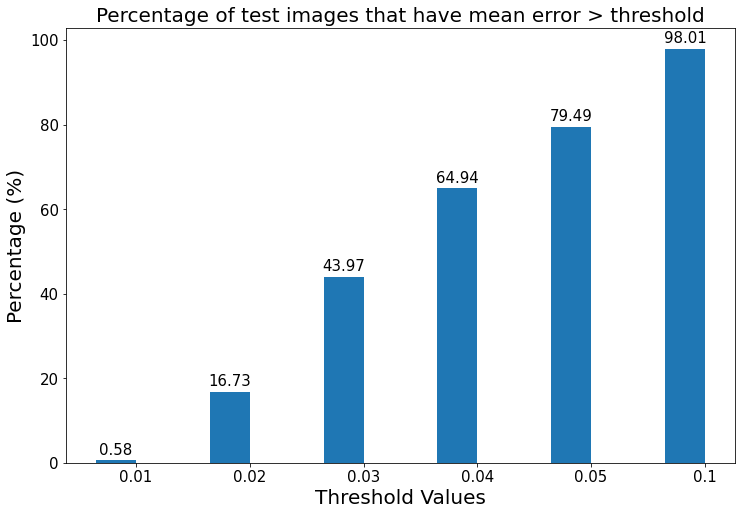

In [12]:
threshold=["0.01","0.02","0.03","0.04","0.05","0.1"]
perca=["0","20","40","60","80","100"]
perc=np.round(abcdef,2)
x = np.arange(len(threshold)) # the label locations
width = 0.35 # the width of the bars
fig, ax = plt.subplots()

ax.set_ylabel('Percentage (%)',fontsize=20)
ax.set_xlabel('Threshold Values',fontsize=20)
ax.set_title('Percentage of test images that have mean error > threshold',fontsize=20)
ax.set_xticks(x)
ax.set_yticklabels(perca,fontsize=15)
ax.set_xticklabels(threshold,fontsize=15)

pps = ax.bar(x - width/2, perc, width, label='threshold',align="center")
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom',fontsize=15)
fig.set_size_inches(12,8, forward=True)
plt.show()

## Inference on Test Data

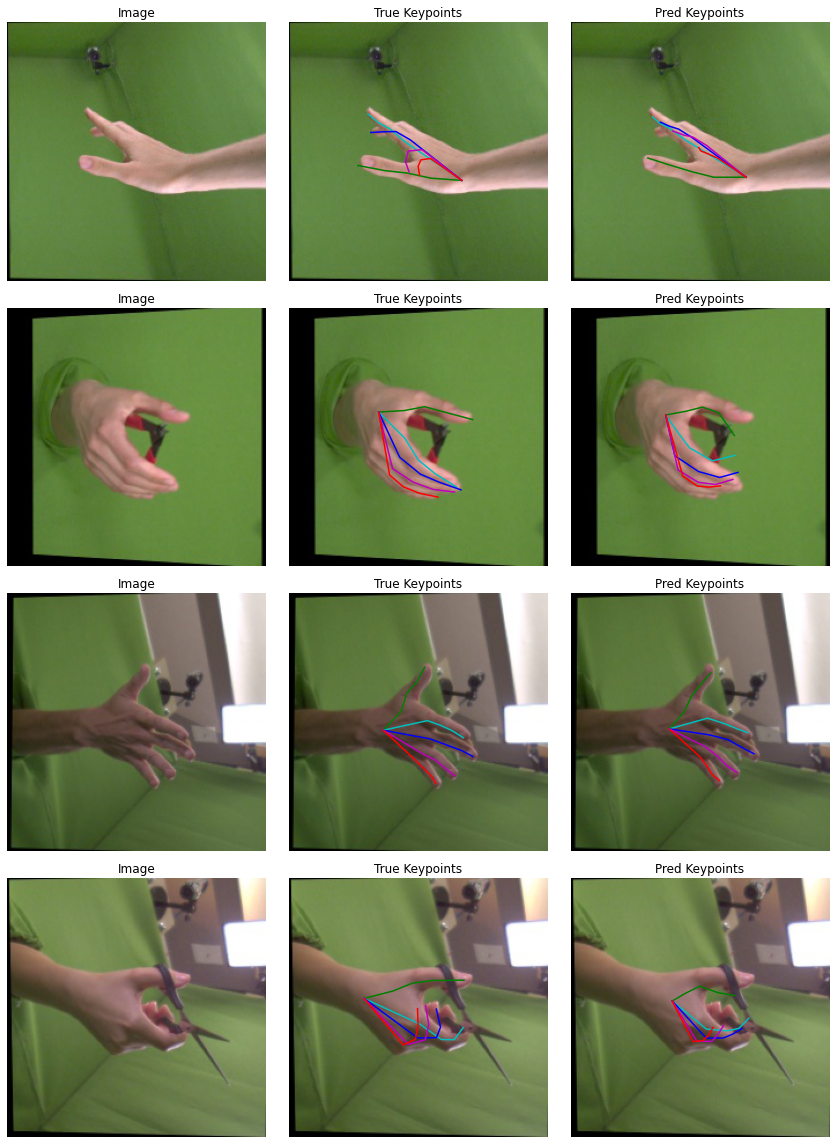

In [13]:
for data in test_dataloader:
    show_batch_predictions(data, model)
    break